# Imports

In [1]:
import os

from verification_system import VerificationSystem

# Testing Single Users

In [2]:
verification_system = VerificationSystem(
    database_path=os.path.join("data", "database"),
)

authorized_users
24-04-08 09:37:30 - Searching data\database\incoming_users\authorized_users\25\010802.jpg in 1826 length datastore
24-04-08 09:37:32 - find function duration 5.542904376983643 seconds


### Previously verified user

In [3]:
verification_system.verify_user(
    user_name="1",
    user_photo_path=verification_system.get_incoming_authorized_user_path(),
)

(False,
 0     0.184427
 1     0.211608
 2     0.323785
 3     0.338584
 4     0.361090
 5     0.366051
 6     0.402765
 7     0.405477
 8     0.409725
 9     0.413963
 10    0.432747
 11    0.433512
 12    0.434237
 13    0.443585
 14    0.451397
 15    0.457316
 16    0.462487
 17    0.462760
 18    0.477086
 Name: distance, dtype: float64)

### Not authorized user

In [4]:
verification_system.verify_user(
    user_name="101",
    user_photo_path=verification_system.get_incoming_unauthorized_user_path(),
)

(False,
 0     0.414499
 1     0.421113
 2     0.421755
 3     0.437628
 4     0.438968
 5     0.441391
 6     0.449794
 7     0.459349
 8     0.466488
 9     0.469024
 10    0.476284
 11    0.493759
 Name: distance, dtype: float64)

### No face detected or above acceptance threshold

In [5]:
verification_system.verify_user(
    user_name="22",
    user_photo_path=verification_system.get_problematic_incoming_authorized_user_path(),
)

(False,
 0     0.199151
 1     0.208707
 2     0.215399
 3     0.221491
 4     0.226376
         ...   
 66    0.482181
 67    0.482275
 68    0.484968
 69    0.489738
 70    0.496640
 Name: distance, Length: 71, dtype: float64)

# Testing Multiple Users

### Incoming Authorized Users

In [6]:
df_incoming_authorized_users = verification_system.verify_multiple_users(
    incoming_users_path=os.path.join(
        "data", "database", "incoming_users", "authorized_users"
    ),
)

In [7]:
df_incoming_authorized_users.head()

,image_path,is_access_granted,distance
0,data\database\incoming_users\authorized_users\...,True,0.141782
1,data\database\incoming_users\authorized_users\...,False,0.111054
2,data\database\incoming_users\authorized_users\...,True,0.076283
3,data\database\incoming_users\authorized_users\...,True,0.195721
4,data\database\incoming_users\authorized_users\...,True,0.179353


In [8]:
verification_system.calculate_access_granted_rate(df_users=df_incoming_authorized_users)

0.9045226130653267

### Incoming Unauthorized Users

In [9]:
df_incoming_unauthorized_users = verification_system.verify_multiple_users(
    incoming_users_path=os.path.join(
        "data", "database", "incoming_users", "unauthorized_users"
    ),
)

In [10]:
df_incoming_unauthorized_users.head()

,image_path,is_access_granted,distance
0,data\database\incoming_users\unauthorized_user...,False,0.414499
1,data\database\incoming_users\unauthorized_user...,False,0.422018
2,data\database\incoming_users\unauthorized_user...,False,0.460712
3,data\database\incoming_users\unauthorized_user...,False,0.407267
4,data\database\incoming_users\unauthorized_user...,False,0.410776


In [11]:
verification_system.calculate_access_granted_rate(
    df_users=df_incoming_unauthorized_users
)

0.0

### Calculate FRR and FRR

In [12]:
far, frr = verification_system.calculate_far_frr(
    df_users_authorized=df_incoming_authorized_users,
    df_users_unauthorized=df_incoming_unauthorized_users,
)
print(f"FAR == {far}, FRR == {frr}")

FAR == 0.09547738693467334, FRR == 0.0


### Plot ROC curve

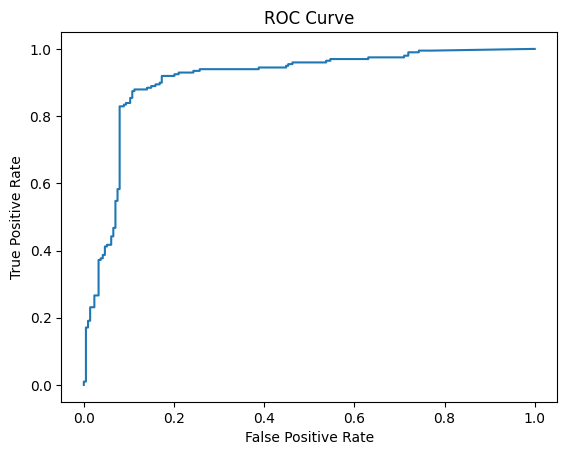

(214, 0, 19, 180)

In [13]:
verification_system.draw_ROC_curve(
    df_users_authorized=df_incoming_authorized_users,
    df_users_unauthorized=df_incoming_unauthorized_users,
)